### Data Mining and Modeling
### Profitability indicators for the most common genre - forecasting early after release

In [183]:
from pymongo import MongoClient
import dateutil.parser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
import statsmodels.formula.api as smf

In [182]:
%matplotlib inline
pd.set_option('max_columns',200)

In [191]:
client = MongoClient()
db = client.boxofficemojo
collection = db.movies
cursor = collection.find()
print 'Number of events = %d' % cursor.count()

Number of events = 14006


In [192]:
df = pd.DataFrame(list(cursor))

In [193]:
df1 = df.ix[:,3:].copy()

In [194]:
remove = ['Producer','Writer','_id']
for item in remove:
    if item in df1:
        del df1[item]

In [195]:
print df1.shape
df1.head()

(14006, 11)


,Distributor,Domestic Total,Genre:,MPAA Rating,OWtheaters,Production Budget,Release Date,Runtime,TLG,openWDG,title
0,Buena Vista,NaN,Sci-Fi Fantasy,PG-13,59982,245000000,"December 18, 2015",136,935518389,247966675,Star Wars: The Force Awakens (2015)
1,Fox,749766139,Sci-Fi Adventure,PG-13,22313,NaN,"December 18, 2009",160,760507625,77025481,Avatar (2009)
2,Paramount,600788188,Romance,PG-13,10710,200000000,"December 19, 1997",194,658672302,28638131,Titanic (1997)
3,Universal,652270625,Sci-Fi Horror,PG-13,48855,150000000,"June 12, 2015",124,652270625,208806270,Jurassic World (2015)
4,Buena Vista,623357910,Action / Adventure,PG-13,47698,220000000,"May 4, 2012",142,623357910,207438708,Marvel's The Avengers (2012)


In [196]:
def transform_column_names(dataframe):
    """Convert column names in a dataframe to lower case and join multi-word names to a single-word name"""
    
    dataframe.columns = [x.lower() for x in dataframe.columns]
    dataframe.columns = [x.replace(" ","").strip(":") for x in dataframe.columns]
    return dataframe.columns

In [197]:
df1.columns = transform_column_names(df1)

In [198]:
df1.head()

,distributor,domestictotal,genre,mpaarating,owtheaters,productionbudget,releasedate,runtime,tlg,openwdg,title
0,Buena Vista,NaN,Sci-Fi Fantasy,PG-13,59982,245000000,"December 18, 2015",136,935518389,247966675,Star Wars: The Force Awakens (2015)
1,Fox,749766139,Sci-Fi Adventure,PG-13,22313,NaN,"December 18, 2009",160,760507625,77025481,Avatar (2009)
2,Paramount,600788188,Romance,PG-13,10710,200000000,"December 19, 1997",194,658672302,28638131,Titanic (1997)
3,Universal,652270625,Sci-Fi Horror,PG-13,48855,150000000,"June 12, 2015",124,652270625,208806270,Jurassic World (2015)
4,Buena Vista,623357910,Action / Adventure,PG-13,47698,220000000,"May 4, 2012",142,623357910,207438708,Marvel's The Avengers (2012)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e1ec810>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x110fda090>]], dtype=object)

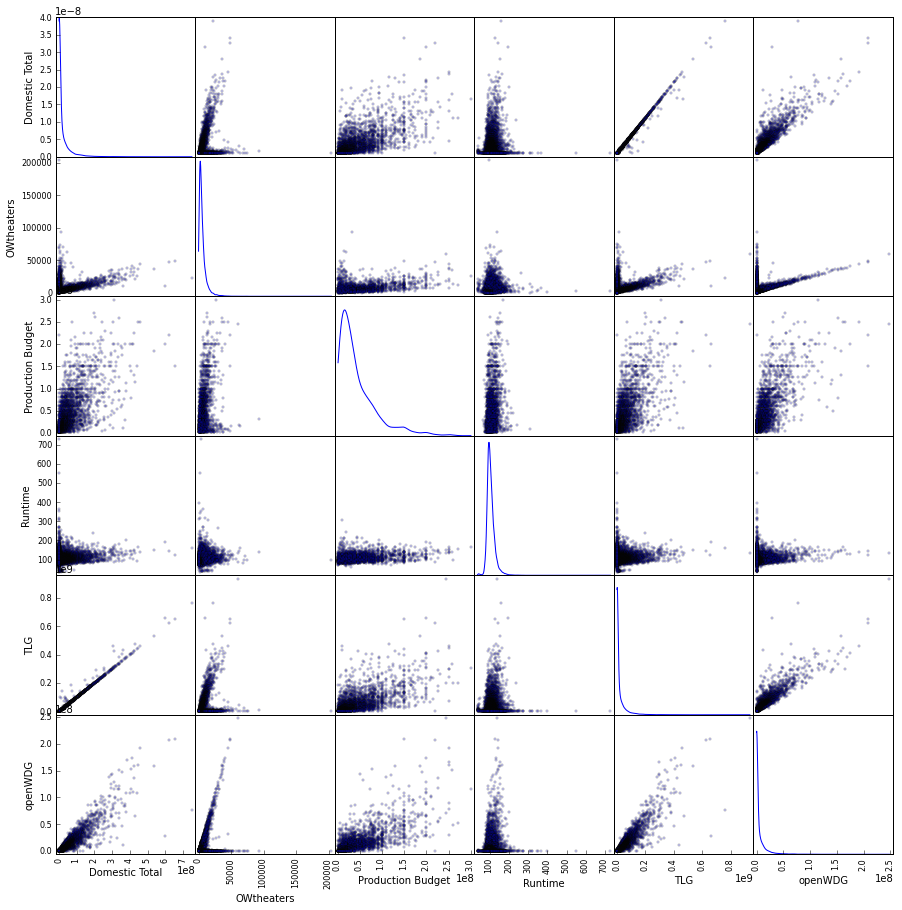

In [73]:
# Plot data
from pandas.tools.plotting import scatter_matrix
scatter_matrix(df,alpha=0.2, figsize=(15,15),diagonal='kde')

In [ ]:
### Where are NaN values:

In [199]:
# Counting NaN values:
NaNs_per_col = df1.isnull().sum(axis=0)
print 'Number of NaNs per column: '
print
print NaNs_per_col

Number of NaNs per column: 

distributor             3
domestictotal         973
genre                   3
mpaarating              3
owtheaters           3523
productionbudget    11157
releasedate             3
runtime               376
tlg                     4
openwdg              1883
title                   0
dtype: int64


(-0.40000000000000002, 10.4, 0.0, 11157.0)

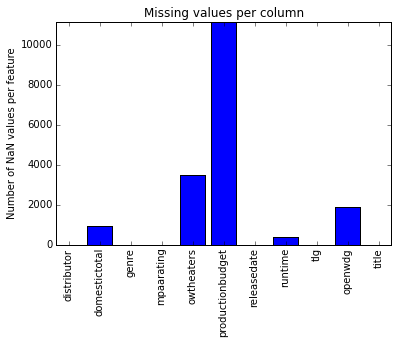

In [200]:
plt.bar(range(len(NaNs_per_col)),NaNs_per_col, align='center')
plt.xticks(range(len(NaNs_per_col.index.tolist())),NaNs_per_col.index.tolist(), rotation=90)
plt.ylabel('Number of NaN values per feature')
plt.title('Missing values per column')
plt.axis('tight')

In [201]:
# Histogramming number of missing features per row; 
# key - number of missing features per row,
# value - number of events
# e.g., (0: 2437,) 2437 events have all the features

NaNs_per_row = df1.isnull().sum(axis=1)
row_NaN = dict()
for row in NaNs_per_row:
    row_NaN[row] = row_NaN.get(row,0) + 1
print  row_NaN

{0: 2437, 1: 7225, 2: 2531, 3: 1638, 4: 163, 5: 9, 10: 3}


(-0.40000000000000002, 10.4, 0.0, 7225.0)

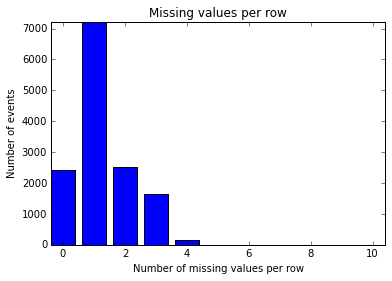

In [202]:
plt.bar(row_NaN.keys(), row_NaN.values(),align = 'center')
plt.xlabel('Number of missing values per row')
plt.ylabel('Number of events')
plt.title('Missing values per row')
plt.axis('tight')

In [226]:
to_remove_NaNs = ['domestictotal','productionbudget','runtime','openwdg','owtheaters']
for _ in to_remove_NaNs:
    df1 = df1[pd.notnull(df1[_])]
df1.isnull().sum(axis=0)    

distributor         0
domestictotal       0
genre               0
mpaarating          0
owtheaters          0
productionbudget    0
releasedate         0
runtime             0
tlg                 0
openwdg             0
title               0
profitability       0
dtype: int64

In [227]:
df1.shape
df1.dtypes

distributor                 object
domestictotal              float64
genre                       object
mpaarating                  object
owtheaters                 float64
productionbudget           float64
releasedate         datetime64[ns]
runtime                    float64
tlg                        float64
openwdg                    float64
title                       object
profitability              float64
dtype: object

In [205]:
# convert object to date
df1['releasedate'] = df1['releasedate'].apply(dateutil.parser.parse, dayfirst=False)

In [207]:
df1['profitability'] = df1['domestictotal'] - df1['productionbudget']

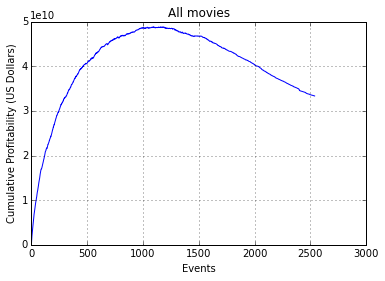

In [208]:
plt.plot(np.cumsum(df1['profitability']))
plt.ylabel('Cumulative Profitability (US Dollars)')
plt.xlabel('Events')
plt.title('All movies')
plt.grid()

In [209]:
print df1.dtypes
print df1.head()

distributor                 object
domestictotal              float64
genre                       object
mpaarating                  object
owtheaters                 float64
productionbudget           float64
releasedate         datetime64[ns]
runtime                    float64
tlg                        float64
openwdg                    float64
title                       object
profitability              float64
dtype: object
    distributor  domestictotal               genre mpaarating  owtheaters  \
2     Paramount      600788188             Romance      PG-13       10710   
3     Universal      652270625       Sci-Fi Horror      PG-13       48855   
4   Buena Vista      623357910  Action / Adventure      PG-13       47698   
5  Warner Bros.      533345358  Action / Adventure      PG-13       36283   
6           Fox      431088295      Sci-Fi Fantasy         PG       21825   

   productionbudget releasedate  runtime        tlg    openwdg  \
2         200000000  1997-12-19      

In [210]:
bygenre = df1.groupby('genre')['profitability'].agg([np.mean,np.std,np.min,np.max,len])
bygenre.head()

,mean,std,amin,amax,len
genre,,,,,
Action,2459250.904762,4.609591e+07,-143577375,163007020,105
Action / Adventure,55100456.485714,1.048602e+08,-96381145,403357910,70
Action / Crime,-3704937.888889,2.750823e+07,-71549530,46128601,18
Action Comedy,9279813.238806,4.522022e+07,-58736034,141719337,67
Action Drama,-9583201.571429,6.958008e+07,-136637525,149721524,21


(-0.40000000000000002,
 62.399999999999999,
 -111020356.81760079,
 262251202.79583883)

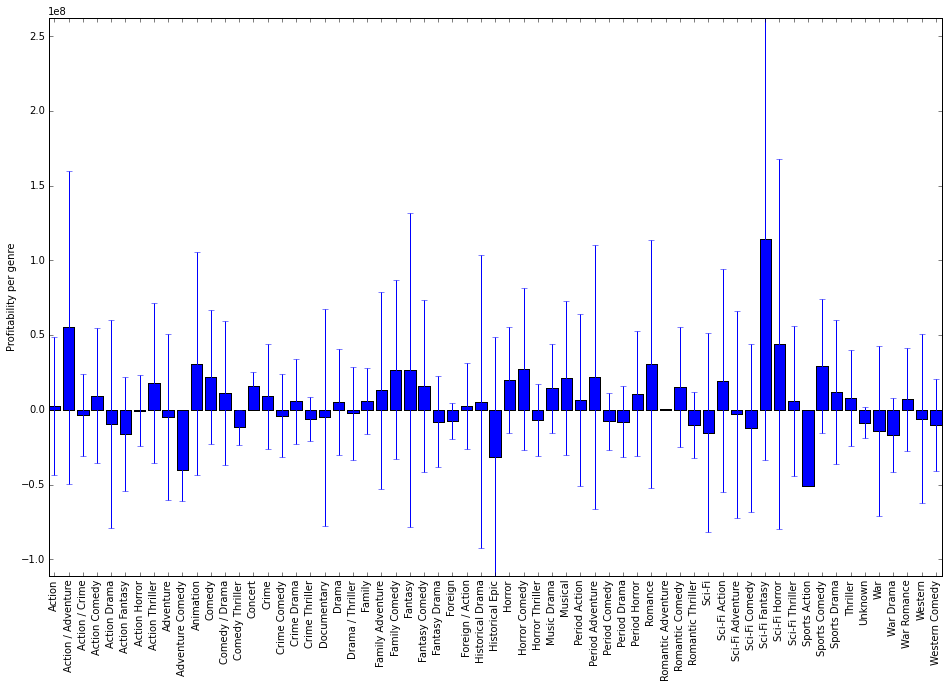

In [211]:
bygl = bygenre.index.tolist()
plt.figure(figsize = (16,10))
plt.bar(range(len(bygenre['mean'])), bygenre['mean'], align = 'center',yerr = bygenre['std'])
plt.xticks(range(len(bygl)),bygl,rotation=90)
plt.ylabel('Profitability per genre')
plt.axis('tight')

(-0.40000000000000002, 7.3999999999999995, -47238988.0, 316088295.0)

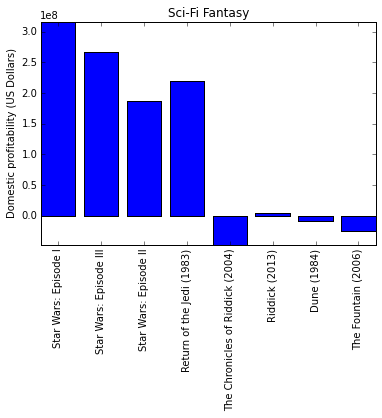

In [212]:
SciFiFantasy = df1[df1['genre'] == 'Sci-Fi Fantasy']
pr = SciFiFantasy['profitability']
ti = SciFiFantasy['title']
plt.bar(range(len(pr)),pr,align = 'center')
plt.xticks(range(len(ti)),ti.tolist(),rotation=90)
plt.ylabel('Domestic profitability (US Dollars)')
plt.title('Sci-Fi Fantasy')
plt.axis('tight')

(-0.40000000000000002, 62.399999999999999, 0.0, 348.0)

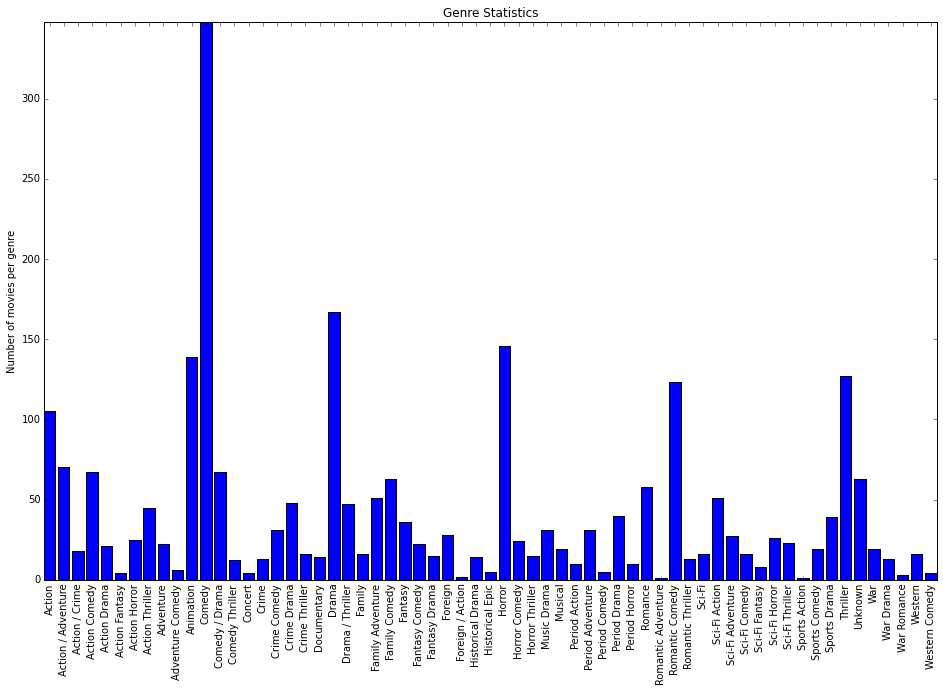

In [213]:
plt.figure(figsize = (16,10))
plt.bar(range(len(bygenre['len'])), bygenre['len'], align = 'center')
plt.xticks(range(len(bygl)),bygl,rotation=90)
plt.ylabel('Number of movies per genre')
plt.title('Genre Statistics')
plt.axis('tight')

In [214]:
selected = bygenre[bygenre['len'] >= 100].index.tolist()
print 'Number of total events in selected genre = ', sum([_ for _ in bygenre['len'] if _ >= 100])
print 'The most common genre selected for models: '
print selected

Number of total events in selected genre =  1155.0
The most common genre selected for models: 
[u'Action', u'Animation', u'Comedy', u'Drama', u'Horror', u'Romantic Comedy', u'Thriller']


In [228]:
# Creating data frame including only data from selected Genre
newd = pd.DataFrame()
for item in selected:
    df2 = df1[df1['genre'] == item]
    newd = pd.concat([newd,df2])
print newd.shape
newd.head(4)

(1134, 12)


,distributor,domestictotal,genre,mpaarating,owtheaters,productionbudget,releasedate,runtime,tlg,openwdg,title,profitability
31,Universal,353007020,Action,PG-13,36760,190000000,2015-04-03,137,353007020,147187040,Furious 7 (2015),163007020
53,Sony / Columbia,304360277,Action,PG-13,25211,200000000,2012-11-09,143,304360277,88364714,Skyfall (2012),104360277
109,Universal,238679850,Action,PG-13,26620,160000000,2013-05-24,130,238679850,97375245,Fast & Furious 6 (2013),78679850
141,Paramount,215409889,Action,PG-13,15835,125000000,2000-05-24,123,215409889,57845297,Mission: Impossible II (2000),90409889


In [229]:
bygenre_sel = newd.groupby('genre')
bygenre_sel['profitability'].describe()

genre                 
Action           count    1.020000e+02
                 mean     2.815127e+06
                 std      4.671320e+07
                 min     -1.435774e+08
                 25%     -2.437269e+07
                 50%     -4.906872e+06
                 75%      2.448062e+07
                 max      1.630070e+08
Animation        count    1.380000e+02
                 mean     3.113032e+07
                 std      7.466422e+07
                 min     -1.286072e+08
                 25%     -1.131612e+07
                 50%      1.542038e+07
                 75%      5.566299e+07
                 max      2.920613e+08
Comedy           count    3.440000e+02
                 mean     2.174644e+07
                 std      4.489155e+07
                 min     -5.756810e+07
                 25%     -5.468486e+06
                 50%      8.456598e+06
                 75%      3.937517e+07
                 max      2.423225e+08
Drama            count    1.560000e+02
  

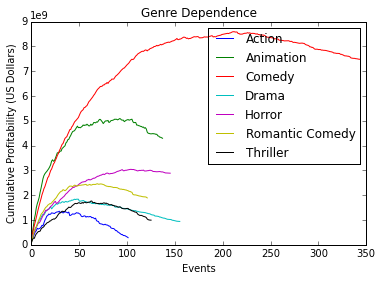

In [230]:
for j in selected:
    
    plt.plot(np.cumsum(newd[newd['genre'] == j]['profitability']),label=j)
    plt.legend()
    
plt.xlabel('Events')
plt.ylabel('Cumulative Profitability (US Dollars)')
plt.title('Genre Dependence')

In [231]:
newd.head()

,distributor,domestictotal,genre,mpaarating,owtheaters,productionbudget,releasedate,runtime,tlg,openwdg,title,profitability
31,Universal,353007020,Action,PG-13,36760,190000000,2015-04-03,137,353007020,147187040,Furious 7 (2015),163007020
53,Sony / Columbia,304360277,Action,PG-13,25211,200000000,2012-11-09,143,304360277,88364714,Skyfall (2012),104360277
109,Universal,238679850,Action,PG-13,26620,160000000,2013-05-24,130,238679850,97375245,Fast & Furious 6 (2013),78679850
141,Paramount,215409889,Action,PG-13,15835,125000000,2000-05-24,123,215409889,57845297,Mission: Impossible II (2000),90409889
147,Universal,209837675,Action,PG-13,23655,125000000,2011-04-29,130,209837675,86198765,Fast Five (2011),84837675


In [219]:
train, test = train_test_split(newd,test_size = 0.2, random_state=42)

print len(train), len(test)

924 231


In [248]:
model = smf.ols(formula='profitability ~ np.log(owtheaters) + genre',data=train)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:          profitability   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     62.22
Date:                Thu, 21 Apr 2016   Prob (F-statistic):           6.48e-73
Time:                        19:34:56   Log-Likelihood:                -17104.
No. Observations:                 905   AIC:                         3.422e+04
Df Residuals:                     897   BIC:                         3.426e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
Intercept               